# Cardiac Admission Outcome Prediction - Model Training

## Dự báo khả năng nhập viện tim mạch

**Mục tiêu:** Train mô hình dự đoán nguy cơ nhập viện tim mạch từ dữ liệu y tế

**Dataset:** `synthetic_cardiac_5000.csv`

**Models:**
- Logistic Regression (Baseline)
- Random Forest (Model chính)

**Evaluation Metrics:** AUC-PR, F1-Score, Precision, Recall

## 1. Setup & Import Libraries

In [1]:
import os
import shutil
from google.colab import drive
drive.mount('/content/drive')

DRIVE_FILE = '/content/drive/MyDrive/temp/bigdata/demo/synthetic_cardiac_5000.csv'

dir_path = os.path.dirname(DRIVE_FILE)
print("📁 Directory exists:", os.path.isdir(dir_path))

if os.path.isfile(DRIVE_FILE):
    shutil.copy(DRIVE_FILE, '/content/')
    print(f"✅ File copied: {DRIVE_FILE}")
else:
    print(f"❌ File not found: {DRIVE_FILE}")


Mounted at /content/drive
📁 Directory exists: True
✅ File copied: /content/drive/MyDrive/temp/bigdata/demo/synthetic_cardiac_5000.csv


In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, count
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

spark = SparkSession.builder \
    .appName("Cardiac Admission Prediction") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()

print(f"✅ Spark {spark.version} ready")

✅ Spark 3.5.1 ready


## 2. Load Data & Exploratory Data Analysis

In [3]:
import os

CSV_PATHS = [
    "synthetic_cardiac_5000.csv",
    "/content/synthetic_cardiac_5000.csv",
    "./synthetic_cardiac_5000.csv"
]

csv_file = next((path for path in CSV_PATHS if os.path.exists(path)), None)

if not csv_file:
    raise FileNotFoundError("synthetic_cardiac_5000.csv not found")

df = spark.read.csv(csv_file, header=True, inferSchema=True)

print("=" * 80)
print(f"Dataset: {df.count()} records, {len(df.columns)} features")
print("=" * 80)
df.printSchema()
df.show(5, truncate=False)

Dataset: 5000 records, 14 features
root
 |-- timestamp: timestamp (nullable = true)
 |-- patient_id: integer (nullable = true)
 |-- heart_rate: double (nullable = true)
 |-- bp_sys: double (nullable = true)
 |-- bp_dia: double (nullable = true)
 |-- spo2: double (nullable = true)
 |-- resp_rate: double (nullable = true)
 |-- age: integer (nullable = true)
 |-- sex: integer (nullable = true)
 |-- hypertension_history: integer (nullable = true)
 |-- diabetes_history: integer (nullable = true)
 |-- heart_failure_history: integer (nullable = true)
 |-- smoking_status: integer (nullable = true)
 |-- admission_label: integer (nullable = true)

+-------------------+----------+----------+------+------+-----+---------+---+---+--------------------+----------------+---------------------+--------------+---------------+
|timestamp          |patient_id|heart_rate|bp_sys|bp_dia|spo2 |resp_rate|age|sex|hypertension_history|diabetes_history|heart_failure_history|smoking_status|admission_label|
+-------

In [4]:
print("=" * 80)
print("CLASS DISTRIBUTION")
print("=" * 80)

df.groupBy("admission_label").count().orderBy("admission_label").show()

total = df.count()
class_0 = df.filter(col("admission_label") == 0).count()
class_1 = df.filter(col("admission_label") == 1).count()

class_weight = class_0 / class_1

print(f"Class 0: {class_0} ({class_0/total*100:.1f}%)")
print(f"Class 1: {class_1} ({class_1/total*100:.1f}%)")
print(f"Imbalance ratio: {class_weight:.2f}:1")
print(f"Class weight: {class_weight:.2f}")

CLASS DISTRIBUTION
+---------------+-----+
|admission_label|count|
+---------------+-----+
|              0| 4527|
|              1|  473|
+---------------+-----+

Class 0: 4527 (90.5%)
Class 1: 473 (9.5%)
Imbalance ratio: 9.57:1
Class weight: 9.57


In [5]:
missing = df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns])
missing.show()
print("✅ No missing values")

+---------+----------+----------+------+------+----+---------+---+---+--------------------+----------------+---------------------+--------------+---------------+
|timestamp|patient_id|heart_rate|bp_sys|bp_dia|spo2|resp_rate|age|sex|hypertension_history|diabetes_history|heart_failure_history|smoking_status|admission_label|
+---------+----------+----------+------+------+----+---------+---+---+--------------------+----------------+---------------------+--------------+---------------+
|        0|         0|         0|     0|     0|   0|        0|  0|  0|                   0|               0|                    0|             0|              0|
+---------+----------+----------+------+------+----+---------+---+---+--------------------+----------------+---------------------+--------------+---------------+

✅ No missing values


In [6]:
CONTINUOUS_COLS = ['heart_rate', 'bp_sys', 'bp_dia', 'spo2', 'resp_rate', 'age']
BINARY_COLS = ['sex', 'hypertension_history', 'diabetes_history', 'heart_failure_history', 'smoking_status']

df.select(CONTINUOUS_COLS).describe().show()

for col_name in BINARY_COLS:
    df.groupBy(col_name).count().show()

+-------+-----------------+------------------+------------------+-----------------+------------------+------------------+
|summary|       heart_rate|            bp_sys|            bp_dia|             spo2|         resp_rate|               age|
+-------+-----------------+------------------+------------------+-----------------+------------------+------------------+
|  count|             5000|              5000|              5000|             5000|              5000|              5000|
|   mean| 90.7518400000001| 130.7701800000003| 80.06903999999994|95.74396000000016|18.130739999999975|           54.1492|
| stddev|23.71628657830335|27.880510421078522|14.364430822450656|3.431375582193994| 5.801615361307572|20.274169471264425|
|    min|             50.0|              90.0|              50.0|             82.9|               8.0|                20|
|    max|            181.4|             220.0|             129.8|            100.0|              41.6|                89|
+-------+---------------

## 3. Data Cleaning & Feature Selection

In [7]:
df_clean = df.drop('timestamp', 'patient_id')

CONTINUOUS_FEATURES = ['heart_rate', 'bp_sys', 'bp_dia', 'spo2', 'resp_rate', 'age']
BINARY_FEATURES = ['sex', 'hypertension_history', 'diabetes_history', 'heart_failure_history', 'smoking_status']
ALL_FEATURES = CONTINUOUS_FEATURES + BINARY_FEATURES

print(f"Features: {len(ALL_FEATURES)} ({len(CONTINUOUS_FEATURES)} continuous + {len(BINARY_FEATURES)} binary)")
print(f"Target: admission_label")
df_clean.printSchema()

Features: 11 (6 continuous + 5 binary)
Target: admission_label
root
 |-- heart_rate: double (nullable = true)
 |-- bp_sys: double (nullable = true)
 |-- bp_dia: double (nullable = true)
 |-- spo2: double (nullable = true)
 |-- resp_rate: double (nullable = true)
 |-- age: integer (nullable = true)
 |-- sex: integer (nullable = true)
 |-- hypertension_history: integer (nullable = true)
 |-- diabetes_history: integer (nullable = true)
 |-- heart_failure_history: integer (nullable = true)
 |-- smoking_status: integer (nullable = true)
 |-- admission_label: integer (nullable = true)



## 4. Train/Validation/Test Split

In [8]:
train_data, temp_data = df_clean.randomSplit([0.7, 0.3], seed=42)
valid_data, test_data = temp_data.randomSplit([0.5, 0.5], seed=42)

total = df_clean.count()
print(f"Train: {train_data.count()} ({train_data.count()/total*100:.1f}%)")
print(f"Valid: {valid_data.count()} ({valid_data.count()/total*100:.1f}%)")
print(f"Test: {test_data.count()} ({test_data.count()/total*100:.1f}%)")

train_data.groupBy("admission_label").count().show()
valid_data.groupBy("admission_label").count().show()
test_data.groupBy("admission_label").count().show()

Train: 3574 (71.5%)
Valid: 735 (14.7%)
Test: 691 (13.8%)
+---------------+-----+
|admission_label|count|
+---------------+-----+
|              1|  343|
|              0| 3231|
+---------------+-----+

+---------------+-----+
|admission_label|count|
+---------------+-----+
|              1|   66|
|              0|  669|
+---------------+-----+

+---------------+-----+
|admission_label|count|
+---------------+-----+
|              1|   64|
|              0|  627|
+---------------+-----+



## 5. Feature Engineering

In [9]:
assembler_continuous = VectorAssembler(
    inputCols=CONTINUOUS_FEATURES,
    outputCol="continuous_vec"
)

scaler = StandardScaler(
    inputCol="continuous_vec",
    outputCol="scaled_continuous",
    withMean=True,
    withStd=True
)

assembler_final = VectorAssembler(
    inputCols=["scaled_continuous"] + BINARY_FEATURES,
    outputCol="features"
)

print(f"✅ Pipeline: VectorAssembler → StandardScaler → VectorAssembler")
print(f"   Output: {len(ALL_FEATURES)}-dimensional feature vector")

✅ Pipeline: VectorAssembler → StandardScaler → VectorAssembler
   Output: 11-dimensional feature vector


In [10]:
train_with_weights = train_data.withColumn(
    'classWeight',
    when(col('admission_label') == 1, class_weight).otherwise(1.0)
)

print(f"Class weights: 0→1.0, 1→{class_weight:.2f}")
train_with_weights.select('admission_label', 'classWeight').show(10)

Class weights: 0→1.0, 1→9.57
+---------------+-----------+
|admission_label|classWeight|
+---------------+-----------+
|              0|        1.0|
|              0|        1.0|
|              0|        1.0|
|              0|        1.0|
|              0|        1.0|
|              0|        1.0|
|              0|        1.0|
|              0|        1.0|
|              0|        1.0|
|              0|        1.0|
+---------------+-----------+
only showing top 10 rows



## 6. Model 1: Logistic Regression (Baseline)

In [11]:
lr = LogisticRegression(
    featuresCol='features',
    labelCol='admission_label',
    weightCol='classWeight',
    maxIter=100,
    regParam=0.01
)

lr_pipeline = Pipeline(stages=[assembler_continuous, scaler, assembler_final, lr])

print("Training Logistic Regression (baseline)...")
lr_model = lr_pipeline.fit(train_with_weights)

evaluator_auc = BinaryClassificationEvaluator(labelCol='admission_label', metricName='areaUnderROC')
evaluator_pr = BinaryClassificationEvaluator(labelCol='admission_label', metricName='areaUnderPR')

lr_predictions = lr_model.transform(valid_data)
lr_auc = evaluator_auc.evaluate(lr_predictions)
lr_pr = evaluator_pr.evaluate(lr_predictions)

print(f"Baseline - AUC-ROC: {lr_auc:.4f}, AUC-PR: {lr_pr:.4f}")

Training Logistic Regression (baseline)...
Baseline - AUC-ROC: 0.9998, AUC-PR: 0.9984


## 7. Model 2: Random Forest (Main Model) với Hyperparameter Tuning

In [12]:
rf = RandomForestClassifier(
    featuresCol='features',
    labelCol='admission_label',
    weightCol='classWeight',
    seed=42
)

rf_pipeline = Pipeline(stages=[assembler_continuous, scaler, assembler_final, rf])

paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [50, 100, 150]) \
    .addGrid(rf.maxDepth, [5, 10, 15]) \
    .addGrid(rf.minInstancesPerNode, [1, 5, 10]) \
    .build()

evaluator = BinaryClassificationEvaluator(labelCol='admission_label', metricName='areaUnderPR')

cv = CrossValidator(
    estimator=rf_pipeline,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    numFolds=3,
    seed=42,
    parallelism=2
)

print(f"Training Random Forest with {len(paramGrid)} param combinations...")
cv_model = cv.fit(train_with_weights)
print("✅ Training complete")

Training Random Forest with 27 param combinations...
✅ Training complete


In [13]:
best_rf_model = cv_model.bestModel
rf_stage = best_rf_model.stages[-1]

print(f"Best params: numTrees={rf_stage.getNumTrees}, maxDepth={rf_stage.getMaxDepth()}, minInstances={rf_stage.getMinInstancesPerNode()}")

rf_predictions = best_rf_model.transform(valid_data)
rf_auc = evaluator_auc.evaluate(rf_predictions)
rf_pr = evaluator_pr.evaluate(rf_predictions)

print(f"\nValidation - AUC-ROC: {rf_auc:.4f}, AUC-PR: {rf_pr:.4f}")
print(f"Improvement: AUC-ROC {(rf_auc-lr_auc)/lr_auc*100:+.1f}%, AUC-PR {(rf_pr-lr_pr)/lr_pr*100:+.1f}%")

Best params: numTrees=150, maxDepth=15, minInstances=1

Validation - AUC-ROC: 0.9911, AUC-PR: 0.9239
Improvement: AUC-ROC -0.9%, AUC-PR -7.5%


## 8. Model Evaluation - Chi Tiết

In [14]:
test_predictions = best_rf_model.transform(test_data)

evaluators = {
    'auc_roc': BinaryClassificationEvaluator(labelCol='admission_label', metricName='areaUnderROC'),
    'auc_pr': BinaryClassificationEvaluator(labelCol='admission_label', metricName='areaUnderPR'),
    'f1': MulticlassClassificationEvaluator(labelCol='admission_label', metricName='f1'),
    'precision': MulticlassClassificationEvaluator(labelCol='admission_label', metricName='weightedPrecision'),
    'recall': MulticlassClassificationEvaluator(labelCol='admission_label', metricName='weightedRecall'),
    'accuracy': MulticlassClassificationEvaluator(labelCol='admission_label', metricName='accuracy')
}

metrics = {name: ev.evaluate(test_predictions) for name, ev in evaluators.items()}

print("=" * 80)
print("TEST SET RESULTS")
print("=" * 80)
for name, value in metrics.items():
    print(f"{name.upper():12s}: {value:.4f}")

TEST SET RESULTS
AUC_ROC     : 0.9956
AUC_PR      : 0.9588
F1          : 0.9743
PRECISION   : 0.9748
RECALL      : 0.9754
ACCURACY    : 0.9754


In [15]:
test_predictions.groupBy('admission_label', 'prediction').count().orderBy('admission_label', 'prediction').show()

tp = test_predictions.filter((col('admission_label') == 1) & (col('prediction') == 1)).count()
tn = test_predictions.filter((col('admission_label') == 0) & (col('prediction') == 0)).count()
fp = test_predictions.filter((col('admission_label') == 0) & (col('prediction') == 1)).count()
fn = test_predictions.filter((col('admission_label') == 1) & (col('prediction') == 0)).count()

precision_c1 = tp / (tp + fp) if (tp + fp) > 0 else 0
recall_c1 = tp / (tp + fn) if (tp + fn) > 0 else 0
f1_c1 = 2 * (precision_c1 * recall_c1) / (precision_c1 + recall_c1) if (precision_c1 + recall_c1) > 0 else 0

print(f"\nClass 1 (Admission) Metrics:")
print(f"  Precision: {precision_c1:.4f}")
print(f"  Recall:    {recall_c1:.4f}")
print(f"  F1-Score:  {f1_c1:.4f}")

+---------------+----------+-----+
|admission_label|prediction|count|
+---------------+----------+-----+
|              0|       0.0|  624|
|              0|       1.0|    3|
|              1|       0.0|   14|
|              1|       1.0|   50|
+---------------+----------+-----+


Class 1 (Admission) Metrics:
  Precision: 0.9434
  Recall:    0.7812
  F1-Score:  0.8547


## 9. Feature Importance Analysis

              Feature  Importance
           heart_rate    0.455423
               bp_sys    0.344946
                 spo2    0.050755
heart_failure_history    0.039465
               bp_dia    0.027216
                  age    0.027096
            resp_rate    0.026714
 hypertension_history    0.014104
       smoking_status    0.005147
                  sex    0.004584
     diabetes_history    0.004549


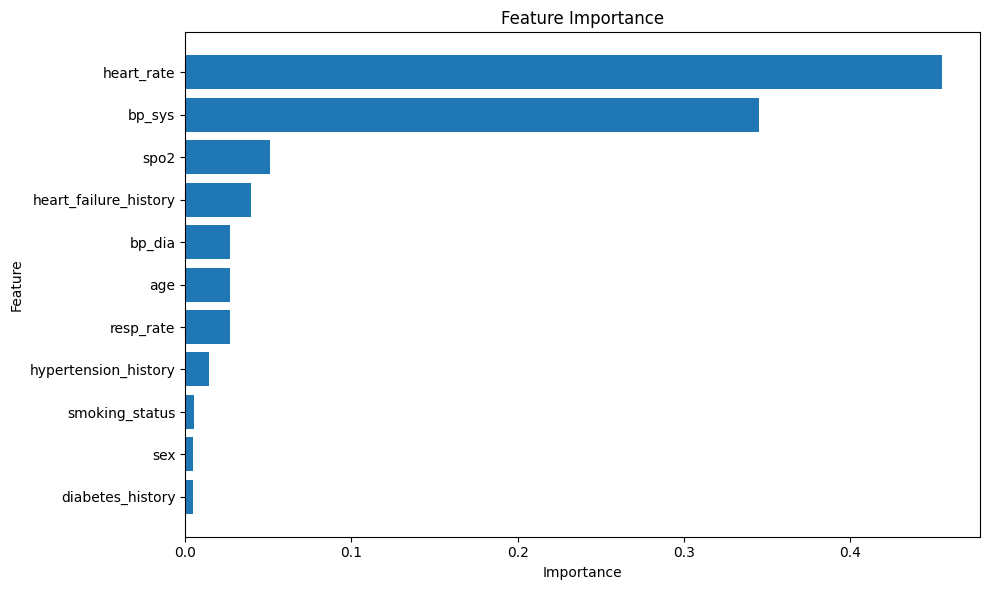


Top 3: heart_rate, bp_sys, spo2


In [16]:
rf_model_stage = best_rf_model.stages[-1]
feature_importance = rf_model_stage.featureImportances.toArray()

importance_df = pd.DataFrame({
    'Feature': ALL_FEATURES,
    'Importance': feature_importance
}).sort_values('Importance', ascending=False)

print(importance_df.to_string(index=False))

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print(f"\nTop 3: {', '.join(importance_df.head(3)['Feature'].tolist())}")

## 10. Save Model

In [17]:
import shutil

MODEL_PATH = "cardiac_rf_model"
best_rf_model.write().overwrite().save(MODEL_PATH)
print(f"✅ Model saved locally: {MODEL_PATH}")

if os.path.exists(DRIVE_MODEL_PATH):
    shutil.rmtree(DRIVE_MODEL_PATH)
    print(f"🗑️  Removed old model from Drive")

shutil.copytree(MODEL_PATH, DRIVE_MODEL_PATH)
print(f"☁️  Model uploaded to Drive: {DRIVE_MODEL_PATH}")

print("\n📁 Model structure:")
for root, dirs, files in os.walk(MODEL_PATH):
    level = root.replace(MODEL_PATH, '').count(os.sep)
    indent = ' ' * 2 * level
    print(f"{indent}{os.path.basename(root)}/")
    if level < 2:
        subindent = ' ' * 2 * (level + 1)
        for file in files[:3]:
            print(f"{subindent}{file}")

✅ Model saved locally: cardiac_rf_model
☁️  Model uploaded to Drive: /content/drive/MyDrive/cardiac_rf_model

📁 Model structure:
cardiac_rf_model/
  metadata/
    .part-00000.crc
    ._SUCCESS.crc
    _SUCCESS
  stages/
    3_RandomForestClassifier_0a87678d2d96/
      data/
      metadata/
      treesMetadata/
    2_VectorAssembler_1b586f141b73/
      metadata/
    1_StandardScaler_49a19771600c/
      data/
      metadata/
    0_VectorAssembler_a0d55f8da75c/
      metadata/
